# Evaluate latent space dimension

Here we want to evaluate the impact on the performances of the latent space third-axis dimensions (i.e. number of channels of ```z_mean``` and ```z_log_var``` tensors).

As usual, we work on the MNIST test set binarized (normal class: 0 vs. all the other digits) and use the AU-ROC metrics to compare the model performances.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.classification import AUCCallback
from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies
from uad.metrics.AU_ROC import compute_ROC, compute_AUC, plot_ROC
from uad.MNIST.one_vs_all import plot_prediction, plot_per_digit_proportion
from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.models.variational_autoencoder import ConvolutionalVAE

!nvidia-smi

2.2.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Sun Jul 12 15:57:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                        

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

x_val, y_val = x_train[-1000:], binarize_set(y_train[-1000:], interest=0)
y_test0 = binarize_set(y_test)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

# training set contains only zeros (for training on zeros)
x_train0, y_train0 = digits_train[0][:-1000], y_train[np.where(y_train[:-1000] == 0)][:-1000]

print(x_train0.shape, y_train0.shape, x_val.shape, y_val.shape)
print(y_test[:5], y_test0[:5])

(4825, 28, 28, 1) (4825,) (1000, 28, 28, 1) (1000,)
[7 2 1 0 4] [1 1 1 0 1]


In [16]:
dims = [1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 24, 32, 64, 128]

l_auc, l_fpr, l_tpr = [], [], []
for k in range(5):
  for i, dim in enumerate(dims):
      print(f"Iteration {i}/{len(dims) - 1} --> dim == {dim}")
      vae = ConvolutionalVAE(dim)
      print(f"VAE latent dim : {vae.latent_dim}")
      vae.compile(optimizer=keras.optimizers.Adam())
      history = vae.fit(x_train0, x_train0, epochs=13, batch_size=128, validation_split=0.2)
      predictions = vae.predict(x_test)
      fpr, tpr, _ = compute_ROC(x_test, predictions, y_test0, criterion="l2", pix_threshold=0.7)
      auc = compute_AUC(fpr, tpr)
      print(f"Latent dim = {vae.latent_dim}, AUC = {auc}")
      l_auc.append(auc)
      l_fpr.append(fpr)
      l_tpr.append(tpr)

aucs = np.array(l_auc)
fprs = np.array(l_fpr)
tprs = np.array(l_tpr)

print(aucs.shape, fprs.shape, tprs.shape)

aucs = np.reshape(l_auc, (5, 14))
fprs = np.reshape(l_auc, (5, 14))
tprs = np.reshape(l_auc, (5, 14))

np.save("/content/gdrive/My Drive/BACMMAN_DISTNET/auc_scores", aucs)
np.save("/content/gdrive/My Drive/BACMMAN_DISTNET/fprs", fprs)
np.save("/content/gdrive/My Drive/BACMMAN_DISTNET/tprs", tprs)

Iteration 0/13 --> dim == 1
VAE latent dim : 1
Epoch 1/13
31/31 [==============================] - 1s 31ms/step - loss: 376.7891 - reconstruction_loss: 376.6537 - kl_loss: 0.1354 - val_loss: 0.0000e+00
Epoch 2/13
31/31 [==============================] - 1s 22ms/step - loss: 332.6937 - reconstruction_loss: 331.6266 - kl_loss: 1.0671 - val_loss: 0.0000e+00
Epoch 3/13
31/31 [==============================] - 1s 21ms/step - loss: 260.8571 - reconstruction_loss: 258.5292 - kl_loss: 2.3279 - val_loss: 0.0000e+00
Epoch 4/13
31/31 [==============================] - 1s 21ms/step - loss: 221.3059 - reconstruction_loss: 218.3812 - kl_loss: 2.9247 - val_loss: 0.0000e+00
Epoch 5/13
31/31 [==============================] - 1s 22ms/step - loss: 199.5845 - reconstruction_loss: 196.2652 - kl_loss: 3.3194 - val_loss: 0.0000e+00
Epoch 6/13
31/31 [==============================] - 1s 22ms/step - loss: 179.4912 - reconstruction_loss: 175.9113 - kl_loss: 3.5799 - val_loss: 0.0000e+00
Epoch 7/13
31/31 [=====

Text(0.5, 0, 'Latent space dimension')

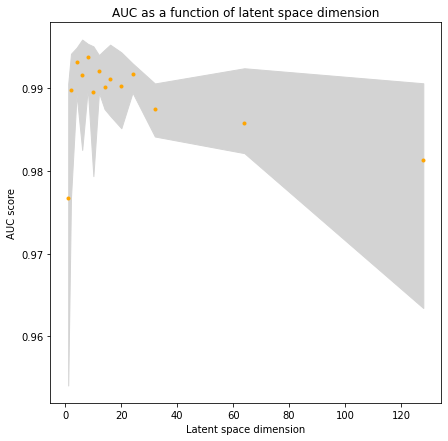

In [35]:
f, axe = plt.subplots(1, 1, figsize=(7, 7))

# plot ROC for each dim
# labels = [f"dim = {dim}" for dim in dims]
# fpr, tpr = fprs[0], tprs[0]
# print(fpr)
# fig, ax = plot_ROC(fpr, tpr, labels)

# plot AUC = f(dim)
axe.plot(dims, np.mean(aucs, axis=0), ".", c="orange", label="mean AUC score")
bounds = np.array([np.min(aucs, axis=0), np.max(aucs, axis=0)])
axe.fill_between(dims, bounds[0], bounds[1], color="lightgrey", label="min-max AUC area")
axe.set_title("AUC as a function of latent space dimension")
axe.set_ylabel("AUC score")
axe.set_xlabel("Latent space dimension")